In [2]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [27]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 

from src.features import build_features
import logging 

import numpy as np

In [4]:
logging.basicConfig(level=logging.INFO)

features = build_features.bag_of_words_tfid_norm()

INFO:src.features.build_features:Building TF-IDF vector + normalizing
INFO:src.features.build_features:Feature building took 55.44 seconds


# Testing Features

I've got the basic bag-of-words + TF-IDF features built, now to do some initial exploration on the corpus...


Text(0.5, 1.0, 'Silhouette Score = 0.01313136348714471')

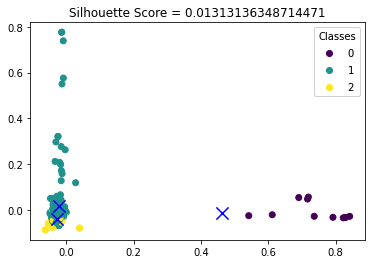

In [5]:
from sklearn.metrics import silhouette_score

random_state = 1
n_clusters=3
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state)
cls.fit(features)

# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

fig, ax = plt.subplots()
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    title="Classes")
ax.add_artist(legend1)

sil_score = silhouette_score(features, labels=cls.predict(features))
plt.title(f"Silhouette Score = {sil_score}")

It looks like there is a kind of interesting cluster to the right (purple).

Let's look at some of the text in that group:

In [51]:
import time
def cluster_report(cls):
    print('\n------------------------------------------------------')
    t0 = time.time()
    print(cls)
    cls.fit(features.toarray())
    fig, ax = plt.subplots()
    scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.labels_)

    legend1 = ax.legend(*scatter.legend_elements(),
                        title="Classes")
    ax.add_artist(legend1)

    if len(set(cls.labels_)) > 1:
        sil_score = silhouette_score(features.toarray(), labels=cls.labels_)
        plt.title(f"Silhouette Score = {np.round(sil_score, 4)}")
    else:
        plt.title("Only one cluster")
    plt.show()
    print(f"Clustering trained in {time.time() - t0} seconds")
    print('------------------------------------------------------\n')


------------------------------------------------------
KMeans(n_clusters=3)


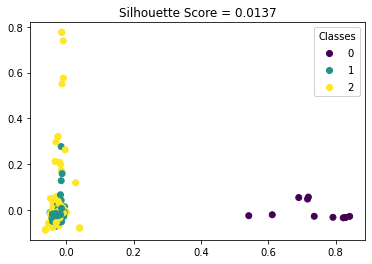

Clustering trained in 0.8720715045928955 seconds
------------------------------------------------------


------------------------------------------------------
MeanShift()


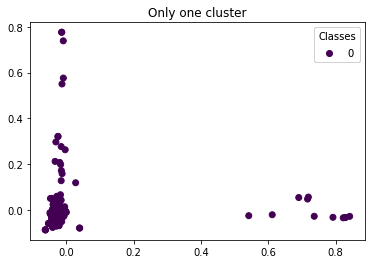

Clustering trained in 17.2832088470459 seconds
------------------------------------------------------


------------------------------------------------------
AffinityPropagation(damping=0.6)


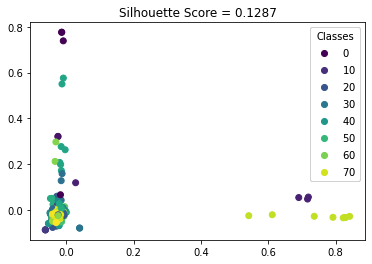

Clustering trained in 0.8948612213134766 seconds
------------------------------------------------------


------------------------------------------------------
AgglomerativeClustering()


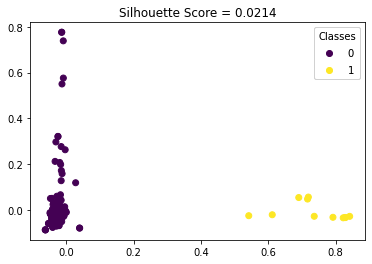

Clustering trained in 0.8569183349609375 seconds
------------------------------------------------------


------------------------------------------------------
DBSCAN()


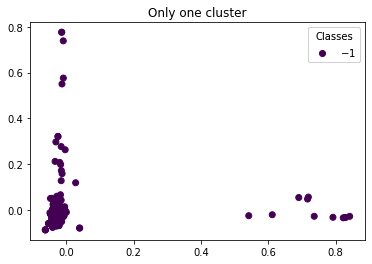

Clustering trained in 0.2823326587677002 seconds
------------------------------------------------------


------------------------------------------------------
MiniBatchKMeans(n_clusters=3, random_state=1)


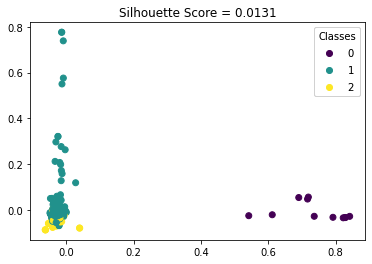

Clustering trained in 0.9884552955627441 seconds
------------------------------------------------------



In [53]:
# test multiple algos:
import pandas as pd
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, AgglomerativeClustering, DBSCAN
n_clusters = 3
algos = [
    KMeans(n_clusters=n_clusters),
    MeanShift(),
    AffinityPropagation(damping=0.6),
    AgglomerativeClustering(),
    DBSCAN(),
    MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state)
]

results = pd.DataFrame()
for alg in algos:
    cluster_report(alg)
    results[alg.__class__.__name__] = alg.labels_

# Save Results

In [52]:

db = DBConnection()
results.to_sql("results", db.conn, if_exists='replace', index_label='id')